In [1]:
# for reading csv into dataframes
import pandas as pd

# for vectorizing text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# for multinomial logistic regression
from sklearn.linear_model import LogisticRegression

# for score metrics (precision, recall and f1)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# for data cleaning/preprocessing
import re
import string
import nltk

# download stop words from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# for the learning curves
import matplotlib.pyplot as plt

################################################################################################################################
# USEFUL FUNCTIONS

# function that performs necessary and useful text cleaning
def data_cleaning(text):
  # lower case text
  text = text.lower()
  # remove unicode characters unreadable in ascii
  text = text.encode('ascii', 'ignore').decode()
  # Remove mentions
  text = re.sub("@\S+", " ", text)
  # Remove URL
  text = re.sub("https*\S+", " ", text)
  # Remove hashtags
  #text = re.sub("#\S+", " ", text)
  # Remove the large spaces/tabs
  text = re.sub('\s{2,}', " ", text)
  # Remove the ' character
  text = re.sub("\'\w+", '', text)
  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  # Remove numbers
  text = re.sub(r'\w*\d+\w*', '', text)
  # Remove stop words
  text = ' '.join([word for word in text.split(' ') if word not in stop_words])
  return text

# function that prints classification scores
def print_scores(y_true, y_pred):
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  score = f1_score(y_true, y_pred, average='weighted')
  print("Weighted average Precision = ", precision)
  print("Weighted average Recall    = ", recall)
  print("Weighted average F1 score  = ", score)

# function that executes training of model using vectorizer on different subsets of the x_train and saves scores
def execute(model, vectorizer, train_examples, x_train, y_train, x_val, y_val, verbose, message) :
  train_scores = []
  validation_scores = []
  print(message)

  for i in train_examples:
    # consider the i first training examples of the training set and their corresponding labels
    train_subset = x_train[:i]
    subset_labels = y_train[:i]
    # vectorize the training subset
    train_subset = vectorizer.fit_transform(train_subset)
    # train the model on this subset of the training set
    model.fit(train_subset, subset_labels)
    # vectorize the validation set on features learned from traning subset
    temp_x_val = vectorizer.transform(x_val)
    # make predictions for the subset of the training set and for the entire validation set
    train_subset_pred = model.predict(train_subset)
    validation_pred = model.predict(temp_x_val)
    # get average f1 score for the training and validation predictions and store them into corresponding lists
    train_scores.append(f1_score(subset_labels, train_subset_pred, average='weighted'))
    validation_scores.append(f1_score(y_val, validation_pred, average='weighted'))

    if (i == y_train.size and verbose == True):
      # calculate and print prediction metrics for entire training set and validation set
      print("\nMetrics for training set :")
      print_scores(y_train, train_subset_pred)
      print("\nMetrics for validation set :")
      print_scores(y_val, validation_pred)
    
  return train_scores, validation_scores

# make subplot of train examples in relation to train and validation scores (plot the learning curves)
def make_subplot(train_examples, train_scores_1, validation_scores_1, title_1, train_scores_2, validation_scores_2, title_2):
  # plot learning curves
  print("\n")
  fig = plt.figure(figsize=(16, 6), dpi=120)
  ax1 = fig.add_subplot(1,2,1)

  ax1.scatter(train_examples, train_scores_1, color='red', label='Training Score')
  ax1.scatter(train_examples, validation_scores_1, color='green', label='Validation Score')
  plt.plot(train_examples, train_scores_1, 'r-')
  plt.plot(train_examples, validation_scores_1, 'g-')
  plt.xlabel("Training Examples")
  plt.ylabel("F1 Score")
  plt.legend()
  plt.title(title_1)

  ax2 = fig.add_subplot(1,2,2,sharey=ax1)

  ax2.scatter(train_examples, train_scores_2, color='red', label='Training Score')
  ax2.scatter(train_examples, validation_scores_2, color='green', label='Validation Score')
  plt.plot(train_examples, train_scores_2, 'r-')
  plt.plot(train_examples, validation_scores_2, 'g-')
  plt.xlabel("Training Examples")
  plt.ylabel("F1 Score")
  plt.legend()
  plt.title(title_2)

  plt.show()

# make plot of train examples in relation to train and validation scores (plot the learning curve)
def make_plot(train_examples, train_scores, validation_scores, title):
  # plot learning curve
  print("\n")
  fig = plt.figure(figsize=(8, 6), dpi=80)
  ax1 = fig.add_subplot(1,1,1)

  ax1.scatter(train_examples, train_scores, color='red', label='Training Score')
  ax1.scatter(train_examples, validation_scores, color='green', label='Validation Score')
  plt.plot(train_examples, train_scores, 'r-')
  plt.plot(train_examples, validation_scores, 'g-')
  plt.xlabel("Training Examples")
  plt.ylabel("F1 Score")
  plt.legend()
  plt.title(title)
  plt.show()

################################################################################################################################

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# MAIN FUNCTIONALITY

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")

#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")

#Take a look at the first examples of the dataset
#training_df.head()

#Get stats about the data
#training_df.describe()

#Check for null values
#In this case there are no missing values, so no action is needed
#training_df.isnull().sum()

#Check for null values
#In this case there are no missing values, so no action is needed
#validation_df.isnull().sum()

#Seperate tweet and label columns into seperate vectors for the training set
x_train = training_df['tweet']                  # Tweet vector, has only the tweets
y_train = training_df['label'].to_numpy()       # Label vector, has only the classification labels

#Seperate tweet and label columns into seperate vectors for the validation set
x_val = validation_df['tweet']                  # Tweet vector, has only the tweets
y_val = validation_df['label'].to_numpy()       # Label vector, has only the classification labels

# apply text cleaning for the tweets as pre-processing for the training set
unclean_x_train = x_train
x_train = x_train.apply(data_cleaning)
x_train = x_train.to_numpy()
# apply text cleaning for the tweets as pre-processing for the validation set
unclean_x_val = x_val
x_val = x_val.apply(data_cleaning)
x_val = x_val.to_numpy()

# select vectorizer for feature extraction from text
# we experiment with different vectorizers and arguments
default_count_vectorizer = CountVectorizer()    # default count vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,1), max_df=0.90, min_df=0.001, max_features=2000) # parametrized count vectorizer
#tfidf_vectorizer = TfidfVectorizer(max_features=2000) # parametrized tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.90, min_df=0.001)

# define the multinomial logistic regression model
model = LogisticRegression(penalty='l2', C=0.8, max_iter=10000, multi_class='multinomial', solver='lbfgs')

# define sizes of the subsets of the training set used for learning curves
train_examples = [2, 500, 2500, 5000, 7500, 10000, 12500, y_train.size]

## Default Vectorizers and no data cleaning lead to overfitting



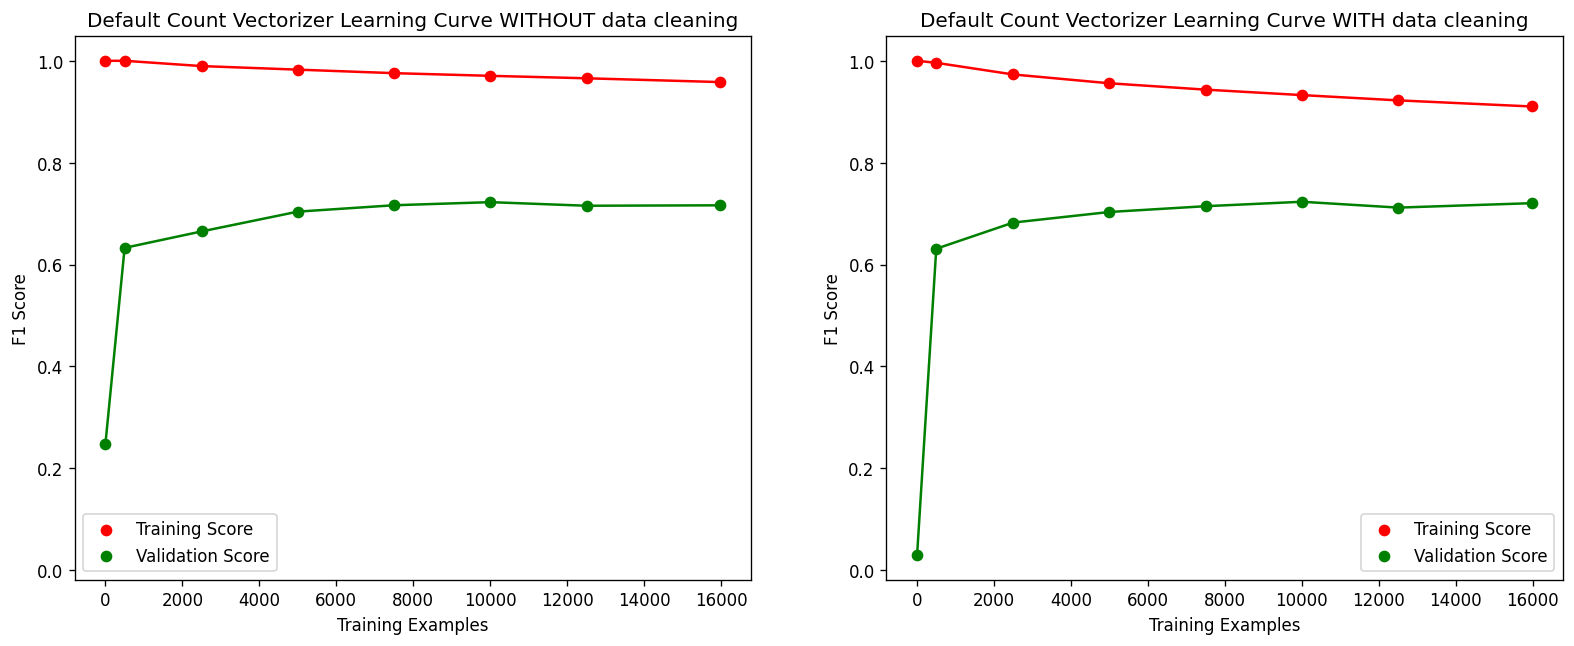

In [3]:
# get scores for default count vectorizer without data cleaning
train_scores_1, validation_scores_1 = execute(model, default_count_vectorizer, train_examples, unclean_x_train, y_train, unclean_x_val, y_val, False, "")
# get scores for default count vectorizer with data cleaning
train_scores_2, validation_scores_2 = execute(model, default_count_vectorizer, train_examples, x_train, y_train, x_val, y_val, False, "")
# subplot learning curves for default count vectorizer without vs with data cleaning 
make_subplot(train_examples, train_scores_1, validation_scores_1, "Default Count Vectorizer Learning Curve WITHOUT data cleaning", train_scores_2, validation_scores_2, "Default Count Vectorizer Learning Curve WITH data cleaning")


## Better Feature selection and Data Cleaning improve fit


Using parametrized count vectorizer

Metrics for training set :
Weighted average Precision =  0.7821927554331496
Weighted average Recall    =  0.7833625438157236
Weighted average F1 score  =  0.7789835916568214

Metrics for validation set :
Weighted average Precision =  0.7130938298570966
Weighted average Recall    =  0.7169149868536372
Weighted average F1 score  =  0.7131124370894087

Using parametrized tfidf vectorizer

Metrics for training set :
Weighted average Precision =  0.7646370664357844
Weighted average Recall    =  0.765272909364046
Weighted average F1 score  =  0.75741317395514

Metrics for validation set :
Weighted average Precision =  0.7110616750639484
Weighted average Recall    =  0.7147239263803681
Weighted average F1 score  =  0.7074440120988589




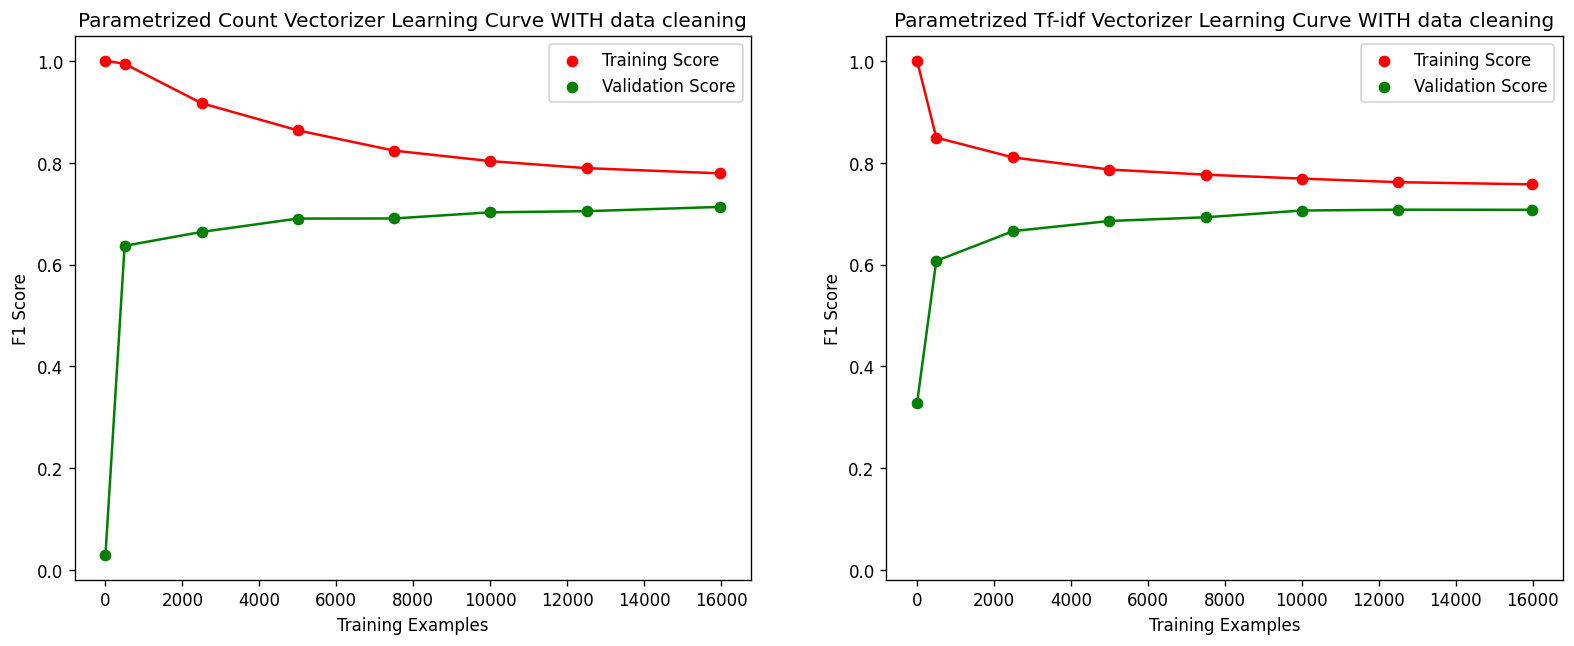

In [4]:
# get and print scores for parametrized count vectorizer 
train_scores_1, validation_scores_1 = execute(model, count_vectorizer, train_examples, x_train, y_train, x_val, y_val, True, "\nUsing parametrized count vectorizer")
# get and print scores for parametrized tfidf vectorizer
train_scores_2, validation_scores_2 = execute(model, tfidf_vectorizer, train_examples, x_train, y_train, x_val, y_val, True, "\nUsing parametrized tfidf vectorizer")
# subplot learning curves for parametrized count vectorizer vs parametrized tfidf vectorizer 
make_subplot(train_examples, train_scores_1, validation_scores_1, "Parametrized Count Vectorizer Learning Curve WITH data cleaning", train_scores_2, validation_scores_2, "Parametrized Tf-idf Vectorizer Learning Curve WITH data cleaning")

## Final Model



Metrics for training set :
Weighted average Precision =  0.7646370664357844
Weighted average Recall    =  0.765272909364046
Weighted average F1 score  =  0.75741317395514

Metrics for validation set :
Weighted average Precision =  0.7110616750639484
Weighted average Recall    =  0.7147239263803681
Weighted average F1 score  =  0.7074440120988589




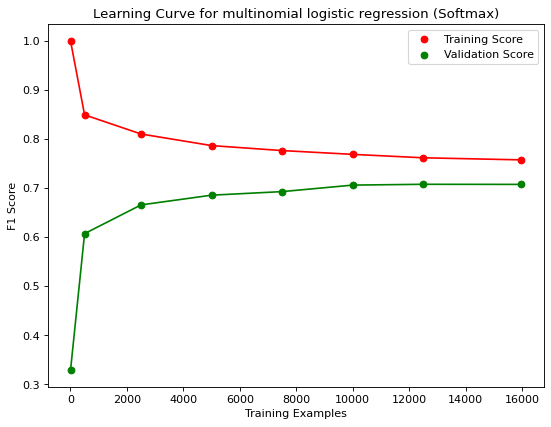

In [7]:
# FINAL MODEL MAIN

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")

#Read the vaccine test set csv file
test_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")   # <------------- REPLACE TEST SET PATH HERE

#Seperate tweet and label columns into seperate vectors for the training set
x_train = training_df['tweet']                  # Tweet vector, has only the tweets
y_train = training_df['label'].to_numpy()       # Label vector, has only the classification labels

#Seperate tweet and label columns into seperate vectors for the test set
x_test = test_df['tweet']                  # Tweet vector, has only the tweets
y_test = test_df['label'].to_numpy()       # Label vector, has only the classification labels

# apply text cleaning for the tweets as pre-processing for the training set
x_train = x_train.apply(data_cleaning)
x_train = x_train.to_numpy()
# apply text cleaning for the tweets as pre-processing for the test set
x_test = x_test.apply(data_cleaning)
x_test = x_test.to_numpy()

# select vectorizer for feature extraction from text
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.90, min_df=0.001)

# define the multinomial logistic regression model
model = LogisticRegression(penalty='l2', C=0.8, max_iter=10000, multi_class='multinomial', solver='lbfgs')

# define sizes of the subsets of the training set used for learning curves
train_examples = [2, 500, 2500, 5000, 7500, 10000, 12500, y_train.size]

# get and print scores for model
train_scores, validation_scores = execute(model, vectorizer, train_examples, x_train, y_train, x_test, y_test, True, "")

# plot learning curve for model 
make_plot(train_examples, train_scores, validation_scores, "Learning Curve for multinomial logistic regression (Softmax)")
